In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import corner
import copy
import pickle
from astropy.io import ascii

%matplotlib inline

## Definitions of fields can be found at:
### confirmed planets:
https://exoplanetarchive.ipac.caltech.edu/docs/API_exoplanet_columns.html
### KOIs:
https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html

In [2]:
KOIs = ascii.read("../../../KOIs_chen2018_goodSystems.csv")
print(KOIs)
print(len(KOIs.colnames))
print(KOIs.colnames)

 kepid   kepoi_name  kepler_name  ...   koi_pmass_err1     koi_pmass_err2  
-------- ---------- ------------- ... ------------------ ------------------
 1026957  K00958.01            -- ...  5.769464972554899  3.244408578305821
 1161345  K00984.01            -- ...  6.326092545818279 3.5574232654922424
 1429589  K04923.01            -- ... 1.5735103860765358 0.7378008287493754
 1431122  K00994.01            -- ...  2.419108737036141 1.0891220900035181
 1432789  K00992.01  Kepler-745 b ...  5.964185807741979  3.027858259246558
 1432789  K00992.02            -- ...  2.437079035986733 1.0697247065679856
 1717722  K03145.01            -- ... 2.6787928971009194 1.3399128949332408
 1717722  K03145.02            -- ... 1.3217080679402717 0.6511151044108447
 1718189  K00993.03            -- ... 3.0588005877402042 1.4588377614817154
 1718189  K00993.02  Kepler-262 b ... 2.9891737858212397  1.378072373671277
     ...        ...           ... ...                ...                ...
12645057  K0

In [3]:
print(len(np.array(KOIs['kepid'])))
print(len(np.unique(np.array(KOIs['kepid']))))

print(len(np.array(KOIs['koi_prad'])[~np.isnan(KOIs["koi_prad"])]))
print(len(np.array(KOIs['koi_ror'])[~np.isnan(KOIs["koi_ror"])]))
print(len(np.array(KOIs['koi_insol'])[~np.isnan(KOIs["koi_insol"])]))

3512
2656
3512
3512
3512


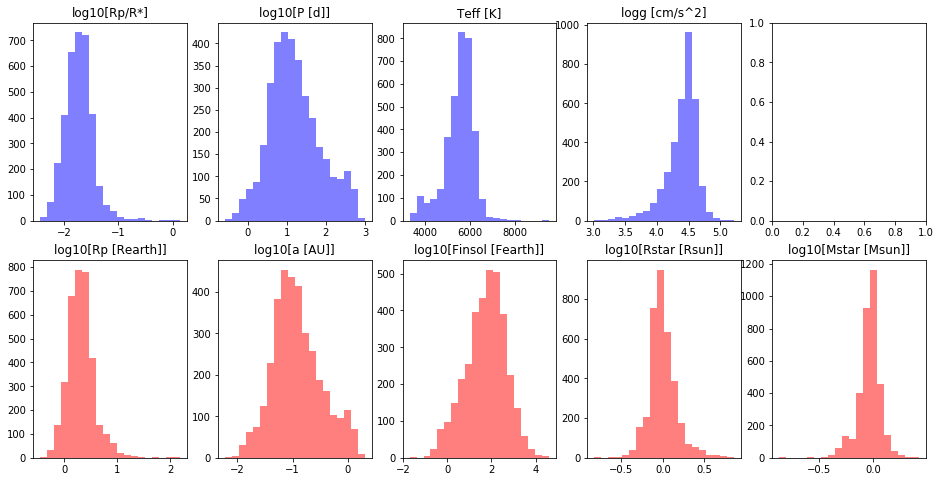

In [4]:
fig, axes = plt.subplots(2,5,figsize=(16,8))

axes[0,0].hist(np.log10(KOIs['koi_ror']),bins=20,color='b',alpha=0.5)
axes[0,0].set_title("log10[Rp/R*]")

axes[0,1].hist(np.log10(KOIs['koi_period']),bins=20,color='b',alpha=0.5)
axes[0,1].set_title("log10[P [d]]")

axes[0,2].hist(KOIs['koi_steff'],bins=20,color='b',alpha=0.5)
axes[0,2].set_title("Teff [K]")

axes[0,3].hist(KOIs['koi_slogg'],bins=20,color='b',alpha=0.5)
axes[0,3].set_title("logg [cm/s^2]")


axes[1,0].hist(np.log10(KOIs['koi_prad']),bins=20,color='r',alpha=0.5)
axes[1,0].set_title("log10[Rp [Rearth]]")

axes[1,1].hist(np.log10(KOIs['koi_sma']),bins=20,color='r',alpha=0.5)
axes[1,1].set_title("log10[a [AU]]")

axes[1,2].hist(np.log10(KOIs['koi_insol']),bins=20,color='r',alpha=0.5)
axes[1,2].set_title("log10[Finsol [Fearth]]")

axes[1,3].hist(np.log10(KOIs['koi_srad']),bins=20,color='r',alpha=0.5)
axes[1,3].set_title("log10[Rstar [Rsun]]")

axes[1,4].hist(np.log10(KOIs['koi_smass']),bins=20,color='r',alpha=0.5)
axes[1,4].set_title("log10[Mstar [Msun]]")

plt.show()



## Want these in a format:
### each row = 1 planetary system, i.e. a list of "planets"
### each "planet" = an array of [Rp/Rstar, P, Teff, logg, Fe/H]

In [5]:
obs_features = np.vstack((np.log10(np.array(KOIs['koi_ror'])).T,np.log10(np.array(KOIs['koi_period'])).T,np.array(KOIs['koi_steff']).T,np.array(KOIs['koi_slogg']).T)).T
mod_features = np.vstack((np.log10(np.array(KOIs['koi_prad'])).T,np.log10(np.array(KOIs['koi_sma'])).T,np.log10(np.array(KOIs['koi_insol'])).T,np.log10(np.array(KOIs['koi_srad'])).T,np.log10(np.array(KOIs['koi_smass'])).T)).T

print(np.shape(obs_features))
print(np.shape(mod_features))


(3512, 4)
(3512, 5)


In [38]:
systems = []

idxs = np.arange(len(KOIs['kepid']))
kepids = np.array(KOIs['kepid'])
unique_kepid = np.sort(np.unique(np.array(KOIs['kepid'])))
print(len(unique_kepid))

np.random.seed(42)
unique_kepid_shuffle = np.random.permutation(unique_kepid)

unique_kepid_70 = np.sort(unique_kepid_shuffle[:int(0.7*len(unique_kepid_shuffle))])
unique_kepid_30 = np.sort(unique_kepid_shuffle[int(0.7*len(unique_kepid_shuffle)):])

print(len(unique_kepid_70))
print(len(unique_kepid_30))

kepids_toloop = unique_kepid_30
features = mod_features
means = np.mean(features,axis=0)
sigmas = np.std(features,axis=0)
savename = "./realPlanets_mod/realKOIs_modFeatures_30percent.txt"

for ID in kepids_toloop:
    goodSystem = True
    system = [ID]
    thisSystem_mask = (kepids == ID)
    thisSystem_idxs = idxs[thisSystem_mask]
    
    kepNames = KOIs['kepoi_name'][thisSystem_idxs]
    Ps = KOIs['koi_period'][thisSystem_idxs]
    #sort KOIs from inner to outer
    sort = np.argsort(Ps)
    thisSystem_idxs = thisSystem_idxs[sort]

    count = KOIs['koi_count'][thisSystem_idxs[0]]

    for j in range(1,count+1):
        planet = []
        
        for k in range(0,np.shape(features)[1]):
            planet.append( ((features[:,k][thisSystem_idxs[j-1]]) - means[k])/sigmas[k] )
            
        system.append((planet))

    systems.append(system)

print(len(systems))

print(type(systems))
print(type(systems[0]))
print(type(systems[0][0]))

with open(savename, "wb") as picklefile:
    pickle.dump(systems, picklefile)

2656
1859
797
797
<class 'list'>
<class 'list'>
<class 'numpy.int64'>


In [39]:
with open(savename, "rb") as picklefile:
    systest = pickle.load(picklefile)

print(len(systest))
print(type(systest))
print(type(systest[0]))
print(type(systest[0][0]))
print(systest[0:2])
print(systems[0:2])

797
<class 'list'>
<class 'list'>
<class 'numpy.int64'>
[[1161345, [0.17351902758821786, -0.8567566116660529, 0.5606692955200596, -0.5442794669777768, -0.05328683431279644]], [1432789, [-0.611257334213653, -0.7719475307717754, 1.032627410948994, 0.49383763717407375, 0.4614187602408189], [0.2599205056183988, -0.262868392593967, 0.5383718184434332, 0.49383763717407375, 0.4614187602408189]]]
[[1161345, [0.17351902758821786, -0.8567566116660529, 0.5606692955200596, -0.5442794669777768, -0.05328683431279644]], [1432789, [-0.611257334213653, -0.7719475307717754, 1.032627410948994, 0.49383763717407375, 0.4614187602408189], [0.2599205056183988, -0.262868392593967, 0.5383718184434332, 0.49383763717407375, 0.4614187602408189]]]


In [9]:
print(2079 + 2*384 + 3*129 + 4*44 + 5*18 + 6*2)

3512


In [10]:
print(2079+384+129+44+18+2)

2656


In [14]:
#number of *planets* in training and test, respectively
print(2459+1053)

3512
